# Set up 


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime
# import tensorflow as tf
# import tensorflow_probability as tfp


In [4]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)

df = df[df["FileCondi"]!="CMat"]
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_giver = df
df0=df.copy()# = df.copy()
# df_giver.columns=df_giver.columns.droplevel(1)
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()
# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

In [5]:
# df.columns=df.columns.droplevel(1)
df.to_csv("df.csv")
df_err.to_csv("df_err.csv")
df_crt.to_csv("df_crt.csv")
df_org.to_csv("df_org.csv")

# R funcitons

In [3]:
%get df_giver --from Python3
# library(plyr)
library(dplyr)
library(ggplot2)
library(lattice)
library(Rmisc)
library(stringr)
library(tidyr)
library(cowplot)
library(plotly)
# source("functions_fromr.r")
d=df_giver


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: 'cowplot'


The following object is masked from 'package:ggplot2':

    ggsave



Attaching package: 'plotly'


The following objects are masked from 'package:plyr':

    arrange, mutate, rename, summarise


The following object is mas

   Length     Class      Mode 
      168 character character 

Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



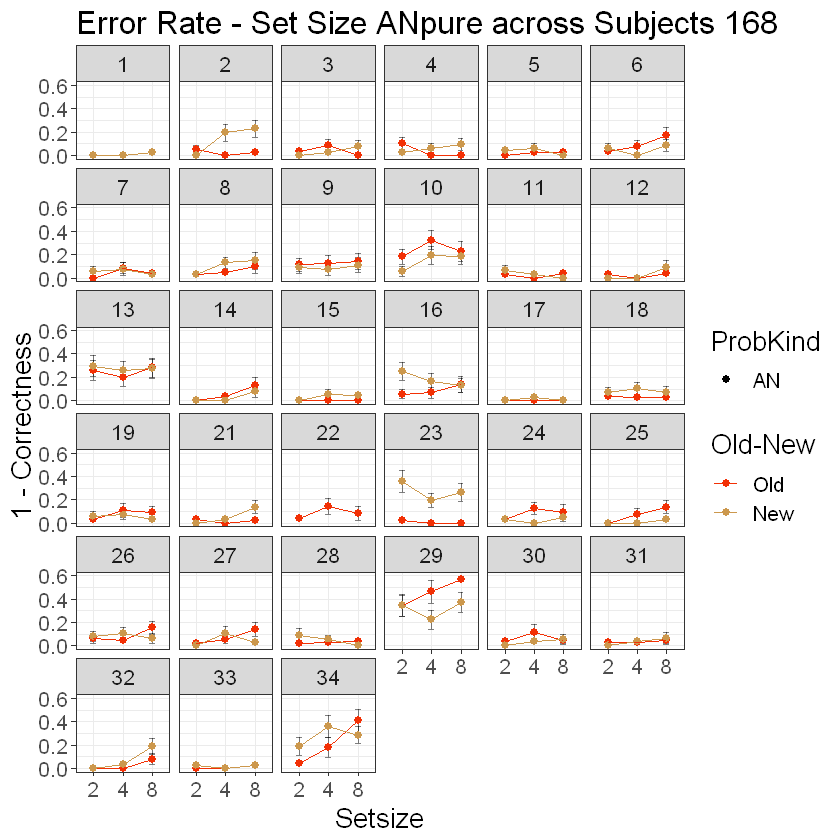

Warning message:
"Removed 106 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



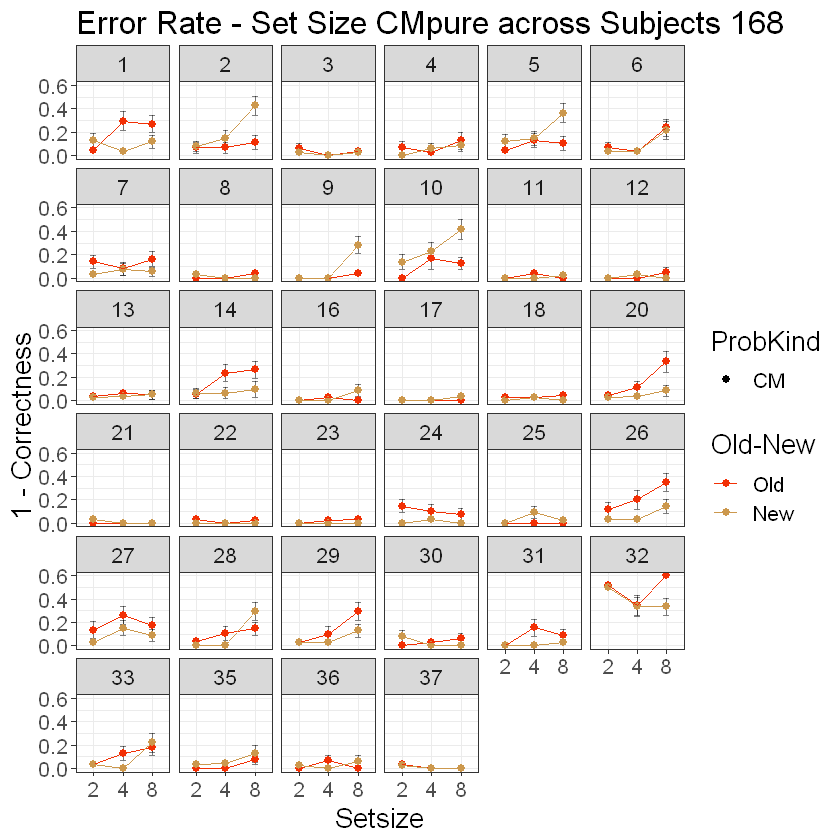

Warning message:
"Removed 115 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



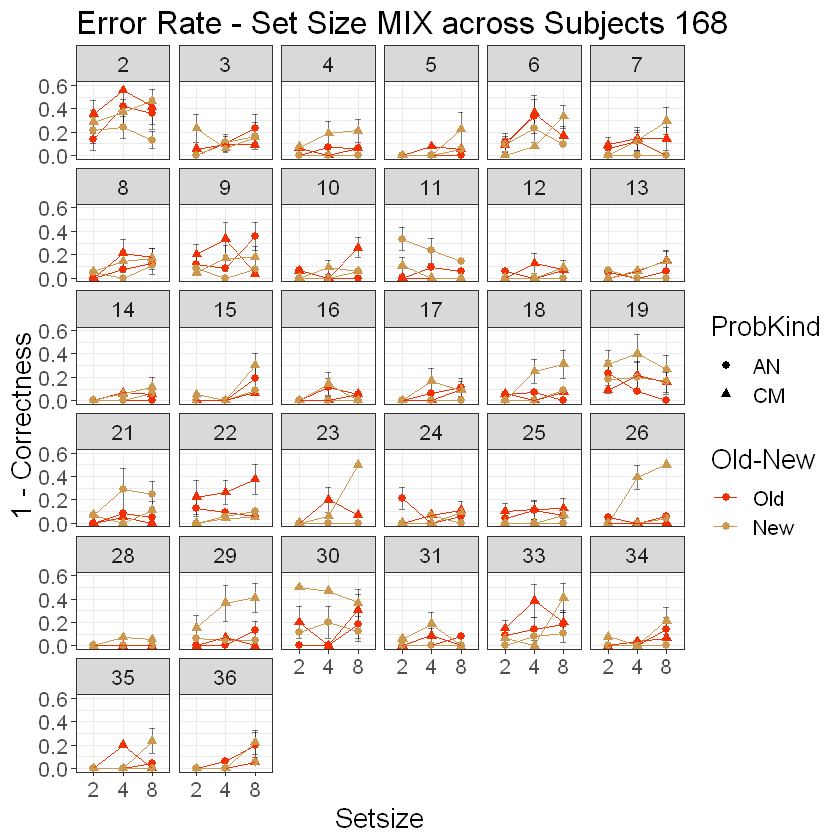

Warning message:
"Removed 36 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


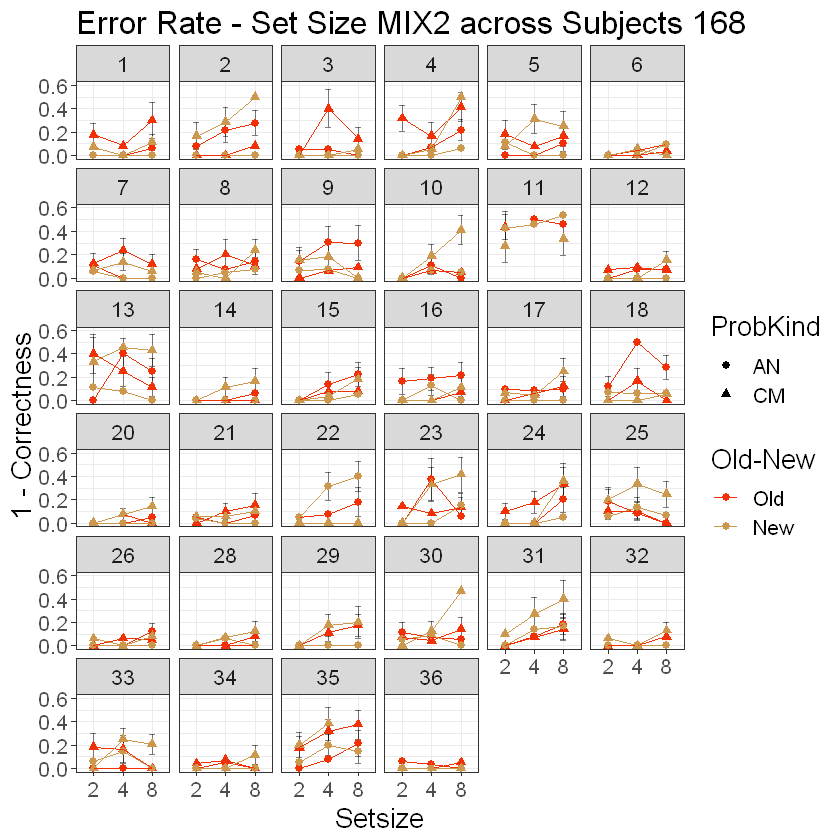

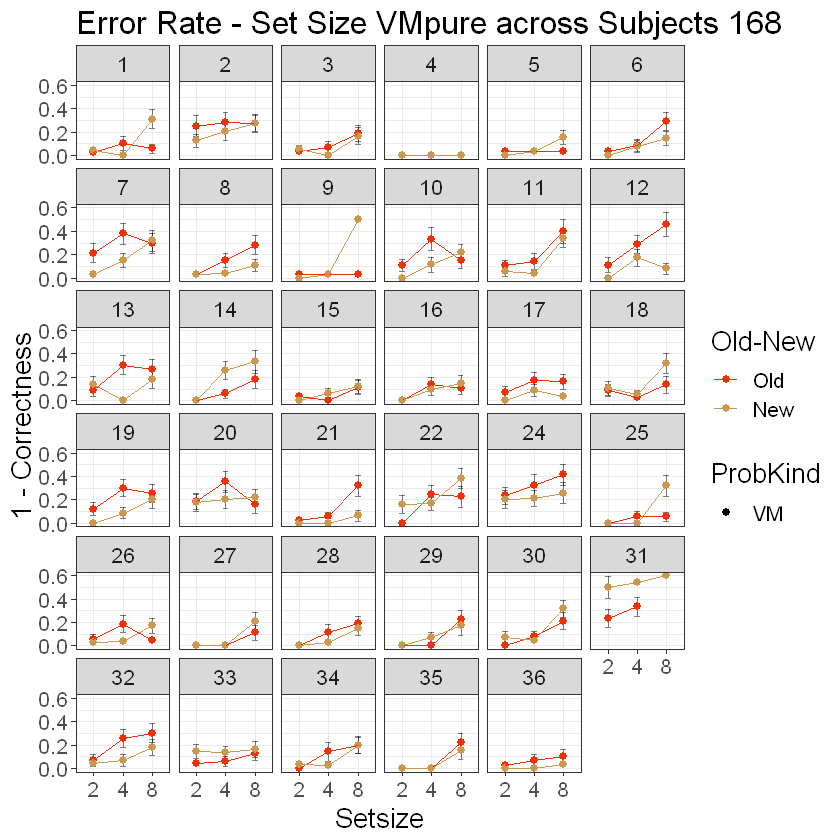

In [7]:
dx=d%>%group_by(Subnum,FileCondi) %>%dplyr::summarise(n())
summary(dx$FileCondi)
all_subnum=length(dx$Subnum)
p.ERdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  d0= d%>% filter(FileCondi==condition)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("Subnum","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Probability of Error")+
    ylim(c(0,0.6))
    print(p)
  
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
#     print(iname)
    p.ERdif(iname,d) #11.... 
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11
#VMpure 31



Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 16 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 12 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



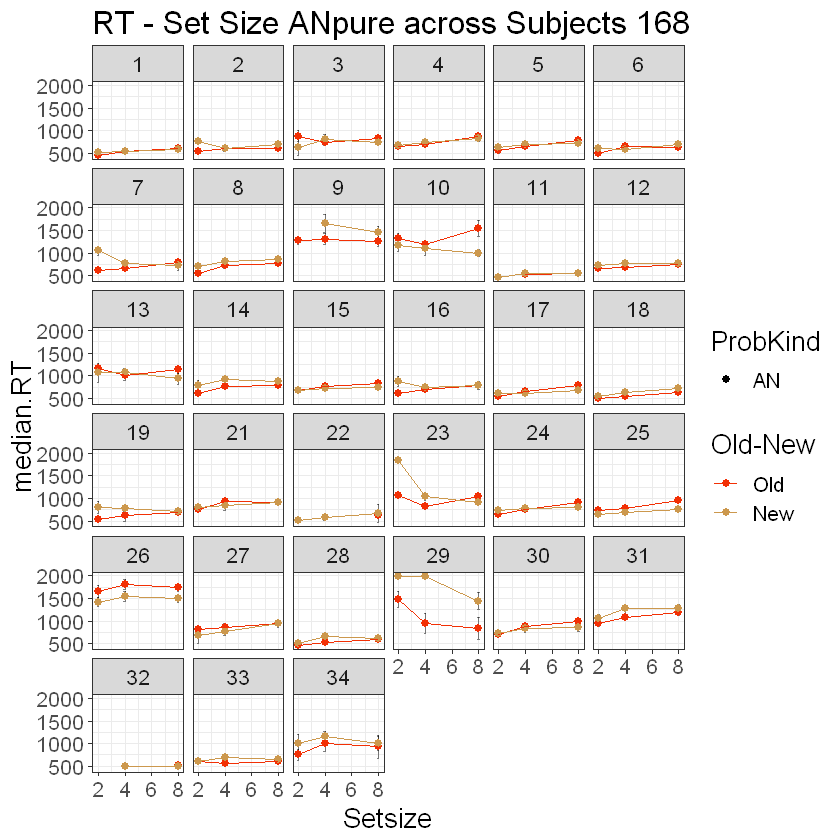

Warning message:
"Removed 18 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



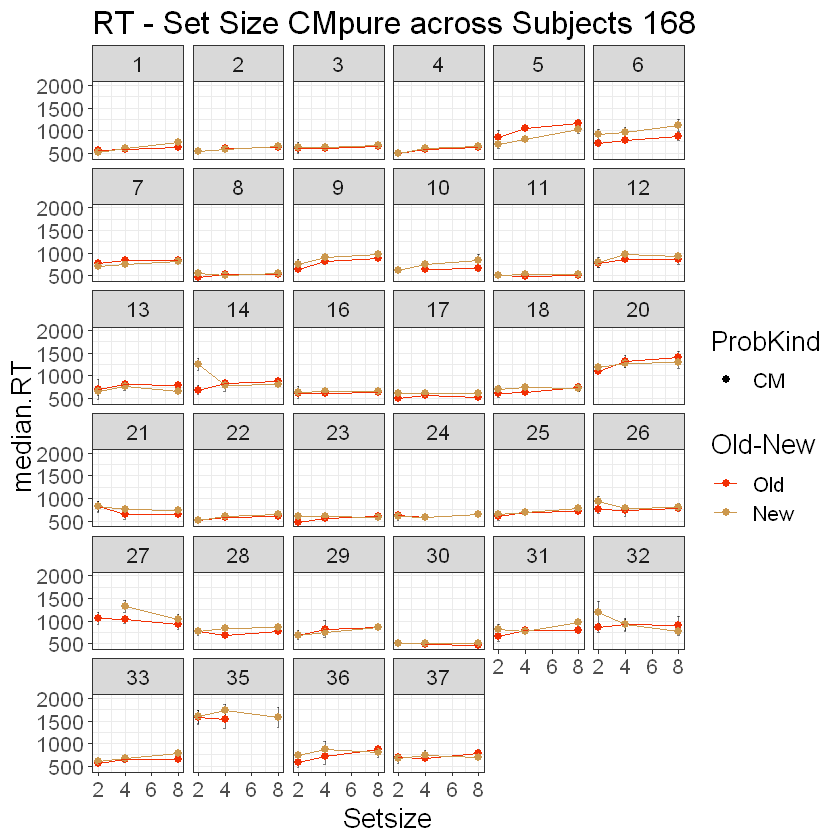

Warning message:
"Removed 21 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



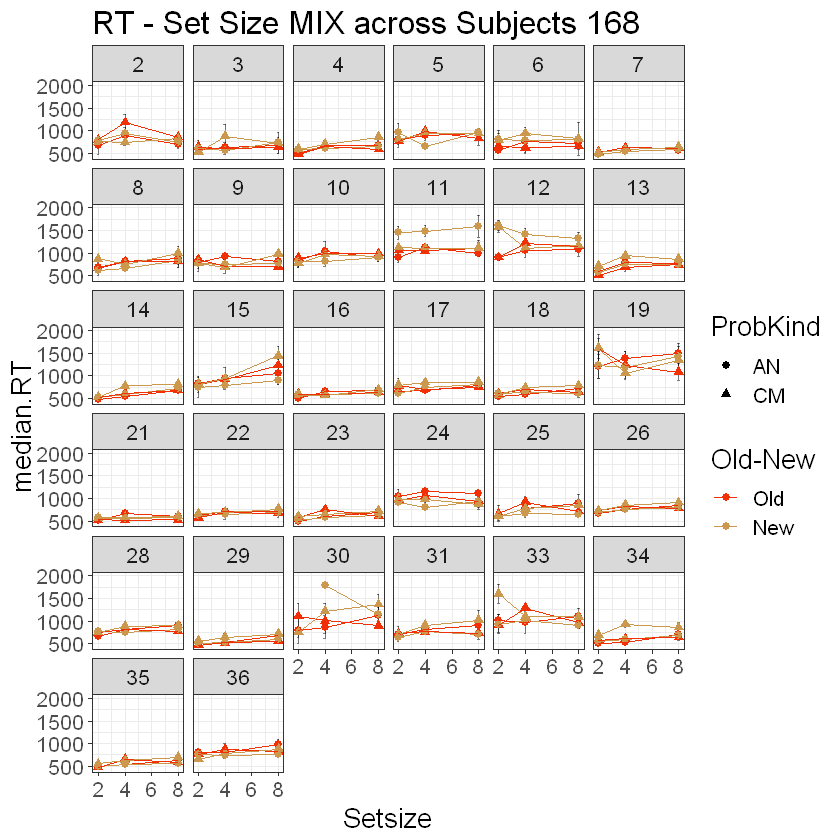

Warning message:
"Removed 10 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


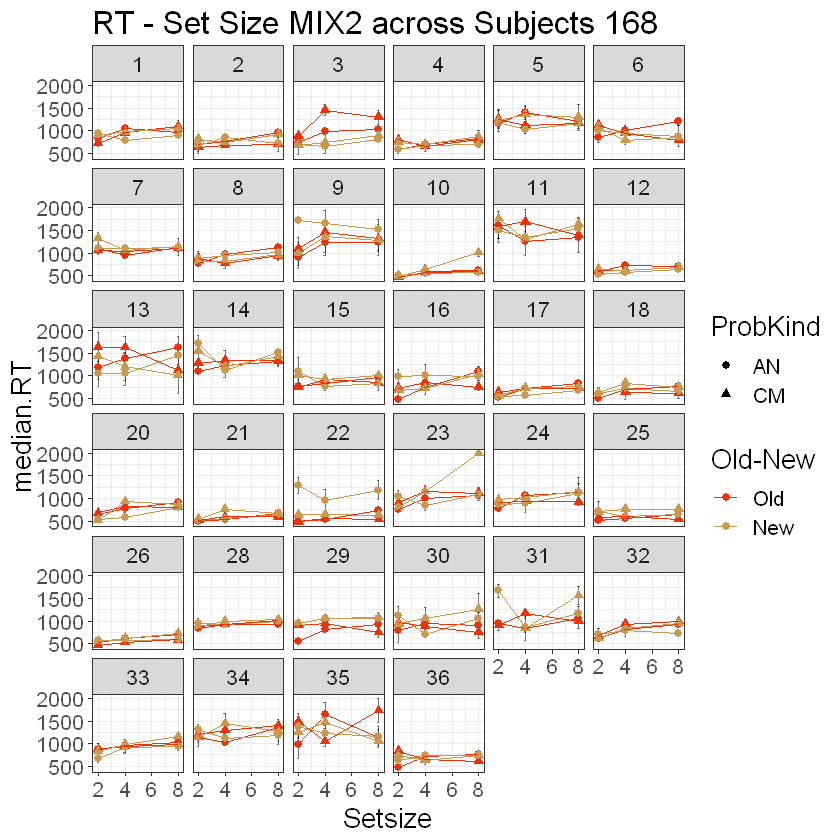

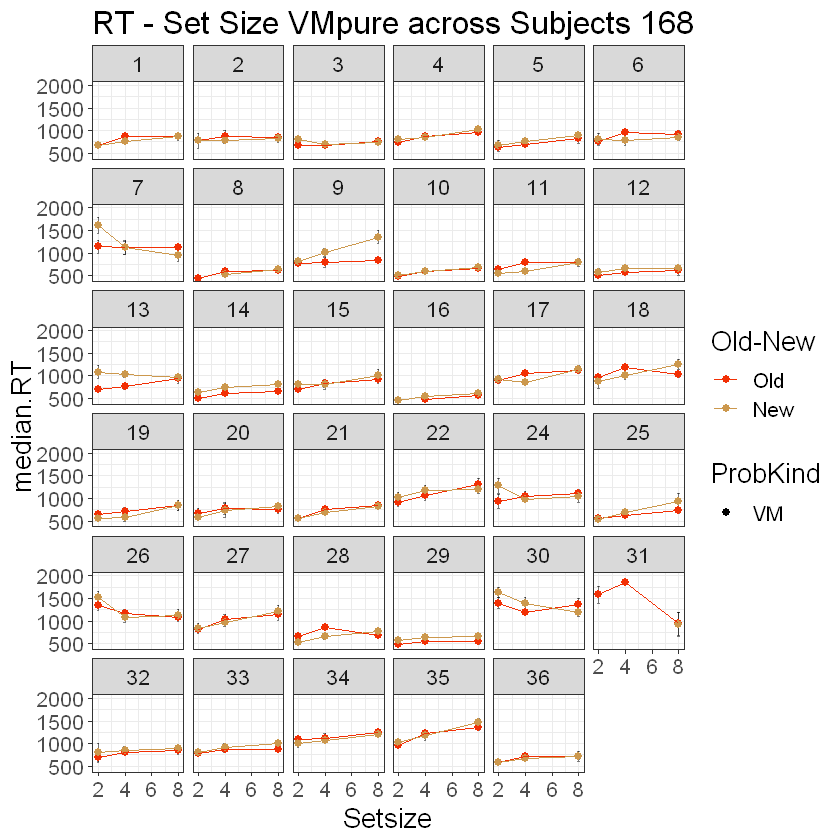

In [9]:
p.RTdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  
  # condition="ANpure"
  d0= d%>% filter(FileCondi==condition)
  dase=d0 %>% group_by(Subnum,Old,Setsize,Stimkind,Correctness) %>%
    dplyr::summarise(median.RT=median(RT),se=sd(RT)/sqrt(n()))

  # print(dase)
  da1se=dase %>% filter(Correctness==1)
  p=ggplot(data=da1se,aes(Setsize,median.RT))+
    geom_errorbar(aes(ymin=(median.RT)-se, ymax=(median.RT)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("RT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Response Time")+
    ylim(c(450,2000))
    print(p)
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
    p.RTdif(iname,d)
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11 - yeah maybe
#VMpure 31 - definatly


In [24]:
d_clean = d%>% filter(!(FileCondi=="ANpure" & Subnum==29)) %>%
    filter(!(FileCondi=="CMpure" & Subnum==32)) %>%
    filter(!(FileCondi=="MIX2" & Subnum==11) )%>%
    filter(!(FileCondi=="VMpure" & Subnum==31))


Automatically converting the following non-factors to factors: FileCondi, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



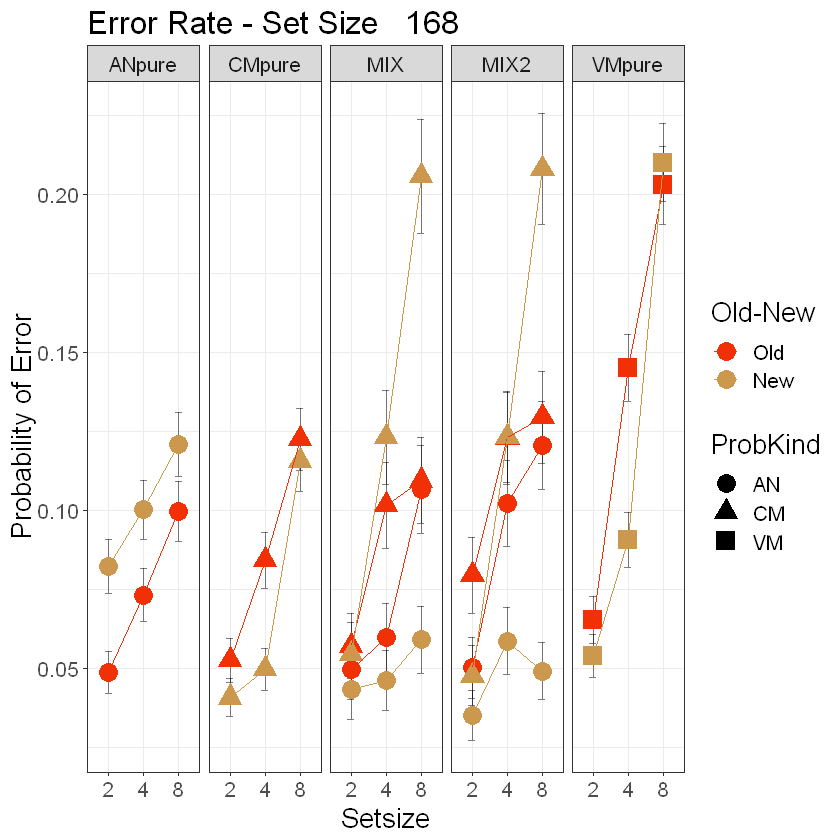

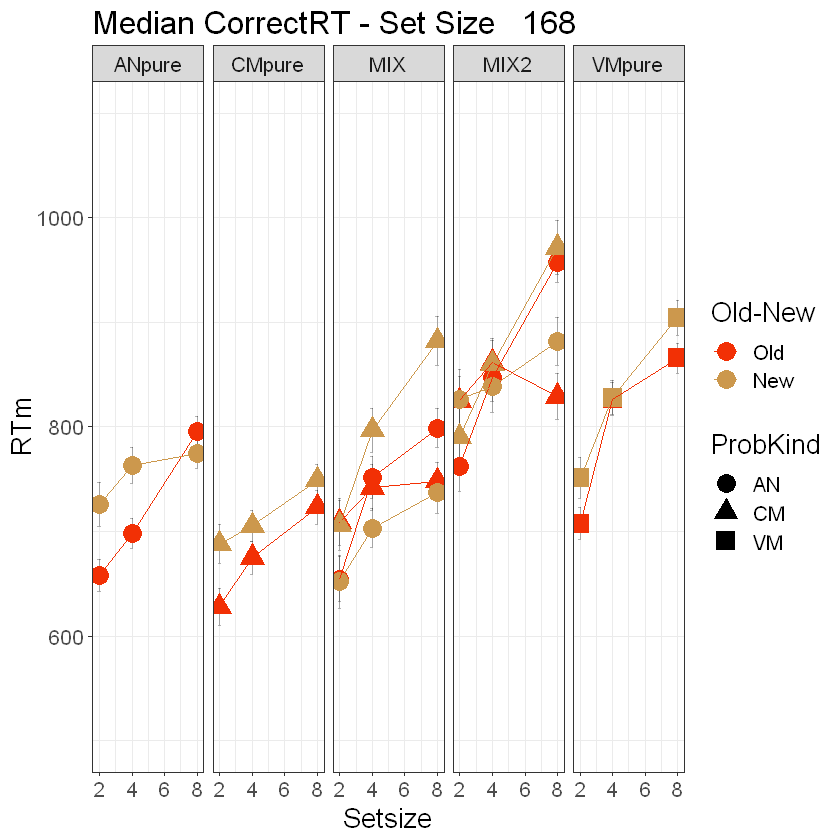

In [27]:
p.medianRT=function(d,tit,BlockFilter){
  cols <- c(`1`=1,`0`=2,`3`=3)
  
  tit=paste(' ',all_subnum," ",tit)
  dase = d %>% filter(Block %in% BlockFilter) %>%
  group_by(FileCondi,Correctness,  Old,Setsize, Stimkind) %>%
  dplyr::summarize(RTm= median(RT),
            se =sd(RT)/sqrt(n()))
  # print(dase)
  da1se=subset(dase,Correctness==1)#;da1se
  p=ggplot(data=da1se,aes(Setsize,RTm))+
    geom_errorbar(aes(ymin=RTm-se, ymax=RTm+se), width=.2,
                 position=position_dodge(.9),alpha=0.3) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Median CorrectRT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(500,1100)+
  facet_wrap(FileCondi~.,ncol=6)
  # scale_colour_manual(name="Error Bars",values=cols, guide = guide_legend(shape = NULL,colour = NULL)) + 
  # scale_shape_manual(name="Bar",values=cols, guide="none") 
  
  return(p)
}
p.ER=function(d,tit,BlockFilter){
  tit=paste(' ',all_subnum," ",tit)
  d0= d %>% filter(Block %in% BlockFilter)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("FileCondi","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
  facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p3=p.ER(d," ",2:9)
p3
p2=p.medianRT(d," ",2:9)
p2

In [ ]:
write.csv(file="Alldata2.csv",d)
d%>%filter(FileCondi=="MIX")

In [4]:
# levels(as.factor(df_giver$FileCondi))
files = c('ANpure' ,'CMpure', 'MIX', 'MIX2', 'VMpure')
c("alpha","beta","s",paste("c",files,sep="_"),paste(rep(c("BDDo","BDDn"),5),rep(files,each=2),sep="_"),
 "t0","t0an","kappa",
 'F_ANpure_AN_oldiold_oldinew',
 'F_CMpure_CM_oldiold_oldinew',
 'L_CMpure_CM_oldiold_newinew',
 'L_CMpure_CM_oldinew_newiold',
 'F_VMpure_VM_oldiold_oldinew',
 'L_VMpure',
 'F_MIX_CM_oldiold_oldinew',
 'L_MIX_CM_oldiold_newinew',
 'L_MIX_CM_oldinew_newiold',
 'F_MIX_AN_oldiold_oldinew',
 'F_MIX2_CM_oldiold_oldinew',
 'L_MIX2_CM_oldiold_newinew',
 'L_MIX2_CM_oldinew_newiold',
 'F_MIX2_AN_oldiold_oldinew')


[1] "alpha"                       "beta"                       
 [3] "s"                           "c_ANpure"                   
 [5] "c_CMpure"                    "c_MIX"                      
 [7] "c_MIX2"                      "c_VMpure"                   
 [9] "BDDo_ANpure"                 "BDDn_ANpure"                
[11] "BDDo_CMpure"                 "BDDn_CMpure"                
[13] "BDDo_MIX"                    "BDDn_MIX"                   
[15] "BDDo_MIX2"                   "BDDn_MIX2"                  
[17] "BDDo_VMpure"                 "BDDn_VMpure"                
[19] "t0"                          "t0an"                       
[21] "kappa"                       "F_ANpure_AN_oldiold_oldinew"
[23] "F_CMpure_CM_oldiold_oldinew" "L_CMpure_CM_oldiold_newinew"
[25] "L_CMpure_CM_oldinew_newiold" "F_VMpure_VM_oldiold_oldinew"
[27] "L_VMpure"                    "F_MIX_CM_oldiold_oldinew"   
[29] "L_MIX_CM_oldiold_newinew"    "L_MIX_CM_oldinew_newiold"   
[31] "F_MIX_AN_oldiold_oldinew"    "F_MIX2_CM_oldiold_oldinew"  
[33] "L_MIX2_CM_oldiold_newinew"   "L_MIX2_CM_oldinew_newiold"  
[35] "F_MIX2_AN_oldiold_oldinew"

    for icondi in filecondis:
        x=threading.Thread(target=work_thread_p,args=(icondi,))
        threads.append(x)
        x.start()
    for icondi, thread in enumerate(threads):
        thread.join()

# Some global setting

In [8]:
global vary_ss, give_c2
vary_ss=1
give_c2=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 0
search_MIX2 = 0
nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()

# ALL Parameter

In [16]:
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


# boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

# s["all"]=0.01
s["ss2"]=0.01
s["ss4"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c["ANpure"] = 0.3938
c["CMpure"] = 0.3938
c["VMpure"] = 0.3938
c["MIX"] = 0.3938
c["MIX2"] = 0.3938
# c["CMat"] = 0.3938
c2=0.3
Old_crit["ANpure"] = 1.9197
New_crit["ANpure"] = -2.33
Old_crit["CMpure"] = 1.9197
New_crit["CMpure"] = -2.33
Old_crit["VMpure"] = 1.9197
New_crit["VMpure"] = -2.33
Old_crit["MIX"] = 1.9197
New_crit["MIX"] = -2.33
Old_crit["MIX2"] = 1.9197
New_crit["MIX2"] = -2.33

t0["all"] = 699.98
t0["ann"] =  699.98
kao = 37

#---CM
F["ANpure_AN_oldiold_oldinew"] = 0.2

F["CMpure_CM_oldiold_oldinew"] = 0.2
L["CMpure_CM_oldiold_newinew"] = 0.2
L["CMpure_CM_oldinew_newiold"] = 0

F["VMpure_VM_oldiold_oldinew"] = 0.2
L["VMpure"] = 0.2 

F["MIX_CM_oldiold_oldinew"] = 0.2
L["MIX_CM_oldiold_newinew"] = 0.2
L["MIX_CM_oldinew_newiold"] = 0.2
F["MIX_AN_oldiold_oldinew"] = 0.2

F["MIX2_CM_oldiold_oldinew"] = 0.2
L["MIX2_CM_oldiold_newinew"] = 0.2
L["MIX2_CM_oldinew_newiold"] = 0.2
F["MIX2_AN_oldiold_oldinew"] = 0.2




# Assign LTM global

In [10]:
def assign_LTM_global(Filecondi,item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    if Filecondi != "VMpure":
        if item_condi == "CM":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_CM_oldiold_oldinew"]
            else: Fnow = 0

            if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":

                Lnow = L[Filecondi+"_CM_oldiold_newinew"]
            elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":

                Lnow = L[Filecondi+"_CM_oldinew_newiold"]
            else: Lnow=0

        elif item_condi == "AN":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_AN_oldiold_oldinew"]
            else: Fnow=0

            Lnow = 0
            
        else: print("wrong condi 1",Filecondi,item_condi, walk+"i"+item)
            
    elif Filecondi == "VMpure":
        
        if item_condi == "VM":
            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
                Fnow = F["VMpure_VM_oldiold_oldinew"]
            else: Fnow = 0
        else: print("wrong condi 2")
            
        Lnow = L["VMpure"]
    else:
        print("wrong filecondi")
    
    return(Fnow + Lnow)

assign_LTM_global("MIX","AN","old","old")


0.2

# Calc A (activation)

In [12]:

def calcA(df):

    
    dnow = df
    a = np.zeros((dnow.shape[0], 8))  #activation
    

    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):

        indexj = j-1
        
        
        if vary_ss==0:
            print("wrong method!!!")
            a[dnow["Lag"]==j,indexj] = m[indexj]
            a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        else:
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==2),indexj] = m[indexj] * s["ss2"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==4),indexj] = m[indexj] * s["ss4"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", s["all"],\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df))

A0=calcA(df)
show =[df["FileCondi"].iloc[i]+\
        "-- "+A0[i].round(5).astype(str)+\
      "--"+ df["Setsize"].iloc[i].astype(str)+\
      "--"+df["Probtype"].iloc[i]+\
      "--"+df["Oldnew"].iloc[i] for i in range(A0.size)]
print(np.sort(show))

['ANpure-- 0.01815--2--AN--new' 'ANpure-- 0.01815--2--AN--new'
 'ANpure-- 0.02652--4--AN--new' 'ANpure-- 0.02652--4--AN--new'
 'ANpure-- 0.03853--8--AN--new' 'ANpure-- 0.03853--8--AN--new'
 'ANpure-- 0.30827--8--AN--old' 'ANpure-- 0.30827--8--AN--old'
 'ANpure-- 0.32246--8--AN--old' 'ANpure-- 0.32246--8--AN--old'
 'ANpure-- 0.34194--8--AN--old' 'ANpure-- 0.34194--8--AN--old'
 'ANpure-- 0.37014--8--AN--old' 'ANpure-- 0.37014--8--AN--old'
 'ANpure-- 0.40219--4--AN--old' 'ANpure-- 0.40219--4--AN--old'
 'ANpure-- 0.4142--8--AN--old' 'ANpure-- 0.4142--8--AN--old'
 'ANpure-- 0.47953--4--AN--old' 'ANpure-- 0.47953--4--AN--old'
 'ANpure-- 0.49153--8--AN--old' 'ANpure-- 0.49153--8--AN--old'
 'ANpure-- 0.63718--2--AN--old' 'ANpure-- 0.63718--2--AN--old'
 'ANpure-- 0.64555--4--AN--old' 'ANpure-- 0.64555--4--AN--old'
 'ANpure-- 0.65755--8--AN--old' 'ANpure-- 0.65755--8--AN--old'
 'ANpure-- 1.19625--2--AN--old' 'ANpure-- 1.19625--2--AN--old'
 'ANpure-- 1.20462--4--AN--old' 'ANpure-- 1.20462--4--AN-

# Calc p (drift rate)

In [13]:
# F["AN_oldiold_oldinew"] = 0.099
def calcp(df):
    
    A = calcA(df)
    dnow = df
    p = np.repeat(3.0, A.shape[0])
#     print(p.size)
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

    for icondi in filecondis:
        
        #only ieterate through probs in that condition
        probs = dnow[dnow["FileCondi"]==icondi]["Probtype"].astype("category").cat.categories.to_numpy()
        for iprob in probs:

            for ion in ["old","new"]:
                    
                tf_ion = (dnow['Oldnew'] == ion)
                tf_iprob = (dnow['Probtype'] == iprob)
                tf_icondi = (dnow["FileCondi"] == icondi)
                
                tf_combi1 = np.logical_and(tf_ion, tf_iprob)
                tf_all = np.logical_and(tf_combi1,tf_icondi)

                IR_old_current = assign_LTM_global(icondi,iprob,"old",ion)
                IR_new_current = assign_LTM_global(icondi, iprob,"new",ion)
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                       "newi"+ion+"--",IR_new_current)

                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c[icondi] + IR_new_current)
#                 print(tf_all.sum(),"***")
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])

    return(np.array(p))


p0=calcp(df)
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
print(np.sort(show))


['ANpure--AN--2--new-- 0.35649' 'ANpure--AN--2--new-- 0.35649'
 'ANpure--AN--2--old-- 0.68009' 'ANpure--AN--2--old-- 0.68009'
 'ANpure--AN--2--old-- 0.78001' 'ANpure--AN--2--old-- 0.78001'
 'ANpure--AN--4--new-- 0.36517' 'ANpure--AN--4--new-- 0.36517'
 'ANpure--AN--4--old-- 0.60462' 'ANpure--AN--4--old-- 0.60462'
 'ANpure--AN--4--old-- 0.6331' 'ANpure--AN--4--old-- 0.6331'
 'ANpure--AN--4--old-- 0.68225' 'ANpure--AN--4--old-- 0.68225'
 'ANpure--AN--4--old-- 0.78103' 'ANpure--AN--4--old-- 0.78103'
 'ANpure--AN--8--new-- 0.37722' 'ANpure--AN--8--new-- 0.37722'
 'ANpure--AN--8--old-- 0.56345' 'ANpure--AN--8--old-- 0.56345'
 'ANpure--AN--8--old-- 0.57021' 'ANpure--AN--8--old-- 0.57021'
 'ANpure--AN--8--old-- 0.57916' 'ANpure--AN--8--old-- 0.57916'
 'ANpure--AN--8--old-- 0.59147' 'ANpure--AN--8--old-- 0.59147'
 'ANpure--AN--8--old-- 0.60933' 'ANpure--AN--8--old-- 0.60933'
 'ANpure--AN--8--old-- 0.63716' 'ANpure--AN--8--old-- 0.63716'
 'ANpure--AN--8--old-- 0.6853' 'ANpure--AN--8--old-- 0.68

In [30]:
# time1=time.time()

# print("time",time.time()-time1)
# p0=calcp(df)
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
# print(np.sort(show))


dd = df[df['FileCondi']=="MIX"]
p0=calcA(dd)
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
print(np.sort(show))

['MIX--AN--2--new-- 0.01815' 'MIX--AN--2--new-- 0.01815'
 'MIX--AN--2--old-- 0.63718' 'MIX--AN--2--old-- 0.63718'
 'MIX--AN--2--old-- 1.19625' 'MIX--AN--2--old-- 1.19625'
 'MIX--AN--4--new-- 0.02652' 'MIX--AN--4--new-- 0.02652'
 'MIX--AN--4--old-- 0.40219' 'MIX--AN--4--old-- 0.40219'
 'MIX--AN--4--old-- 0.47953' 'MIX--AN--4--old-- 0.47953'
 'MIX--AN--4--old-- 0.64555' 'MIX--AN--4--old-- 0.64555'
 'MIX--AN--4--old-- 1.20462' 'MIX--AN--4--old-- 1.20462'
 'MIX--AN--8--new-- 0.03853' 'MIX--AN--8--new-- 0.03853'
 'MIX--AN--8--old-- 0.30827' 'MIX--AN--8--old-- 0.30827'
 'MIX--AN--8--old-- 0.32246' 'MIX--AN--8--old-- 0.32246'
 'MIX--AN--8--old-- 0.34194' 'MIX--AN--8--old-- 0.34194'
 'MIX--AN--8--old-- 0.37014' 'MIX--AN--8--old-- 0.37014'
 'MIX--AN--8--old-- 0.4142' 'MIX--AN--8--old-- 0.4142'
 'MIX--AN--8--old-- 0.49153' 'MIX--AN--8--old-- 0.49153'
 'MIX--AN--8--old-- 0.65755' 'MIX--AN--8--old-- 1.21663'
 'MIX--CM--2--new-- 0.01815' 'MIX--CM--2--new-- 0.01815'
 'MIX--CM--2--old-- 0.63718' 'MIX

# RW 

In [19]:

def calc_theoretical_RW(df, which):
    
    #which = "err" or 'crt'

    A = calcA(df)
    p = calcp(df)
    q = 1-p
    
    dnow = df
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    for ifile in filecondis: 
        
        gen_tf = dnow["FileCondi"]==ifile
        AA = Old_crit[ifile]
        BB = -New_crit[ifile] # bb is a postive number
        
        if which=="crt":
            
            pq = (p[gen_tf]/q[gen_tf])
            theta1[gen_tf] = (pq**(AA+BB)+1)/(pq**(AA+BB)-1)
            theta2[gen_tf] = (pq**BB+1)/(pq**BB-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (AA/3)*(2*BB+AA)
            
            theta11[gen_tf] = (pq**(-(AA+BB))+1)/(pq**(-(AA+BB))-1)
            theta22[gen_tf] = (pq**-AA+1)/(pq**-AA-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta11[tf]*(AA+BB) - theta22[tf]*AA)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (BB/3)*(2*AA+BB)
            
#             if ifile!= "MIX" and ifile!="MIX2":
#                 pred_rt[gen_tf] = t0["all"] + kao * exp_nstep[gen_tf]

        #------------------- correct response
        elif which == "err":
            
            qp = (q[gen_tf]/p[gen_tf])
            qptfn =np.logical_and(p!=q,gen_tf)
            qptf =np.logical_and(p==q,gen_tf)

            p_resp_old[qptfn] = ((1-qp**BB)/(1-qp**(AA+BB)))[p[gen_tf]!=q[gen_tf]]
            p_resp_old[qptf] = BB/(AA+BB)
    #------------------
#     else: 
#                 print(ifile)
    if which=="crt":
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

#         pred_rt[suprise] = t0["all"] + kao * exp_nstep[suprise]
        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]
#     for i in range(df.size):
#         print(df["FileCondi"][i],df["Probtype"][i],df["Oldnew"][i],suprise[i])

    #------------------
            
    if which == "err":
        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          


# time1=time.time()
# ok1=calc_theoretical_RW(df_err,"err")
# ok2=calc_theoretical_RW(df_crt,"crt")
# print(time.time()-time1)

# rw_ct=calc_theoretical_RW(df,"crt")
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))

# RW=calc_theoretical_RW(df,"crt")
# show =[dd["FileCondi"].iloc[i]+\
#        "--"+dd["Probtype"].iloc[i]+\
#        "--"+ dd["Setsize"].iloc[i].astype(str)+\
#        "--"+dd["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))


rw=calc_theoretical_RW(df,"err")
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+rw[i].round(5).astype(str) for i in range(A0.size)]
print(np.sort(show))

['ANpure--AN--2--new-- 0.7382' 'ANpure--AN--2--new-- 0.7382'
 'ANpure--AN--2--old-- 0.86246' 'ANpure--AN--2--old-- 0.86246'
 'ANpure--AN--2--old-- 0.952' 'ANpure--AN--2--old-- 0.952'
 'ANpure--AN--4--new-- 0.72304' 'ANpure--AN--4--new-- 0.72304'
 'ANpure--AN--4--old-- 0.75197' 'ANpure--AN--4--old-- 0.75197'
 'ANpure--AN--4--old-- 0.79804' 'ANpure--AN--4--old-- 0.79804'
 'ANpure--AN--4--old-- 0.86507' 'ANpure--AN--4--old-- 0.86507'
 'ANpure--AN--4--old-- 0.95262' 'ANpure--AN--4--old-- 0.95262'
 'ANpure--AN--8--new-- 0.70134' 'ANpure--AN--8--new-- 0.70134'
 'ANpure--AN--8--old-- 0.67713' 'ANpure--AN--8--old-- 0.67713'
 'ANpure--AN--8--old-- 0.69002' 'ANpure--AN--8--old-- 0.69002'
 'ANpure--AN--8--old-- 0.70672' 'ANpure--AN--8--old-- 0.70672'
 'ANpure--AN--8--old-- 0.72905' 'ANpure--AN--8--old-- 0.72905'
 'ANpure--AN--8--old-- 0.75993' 'ANpure--AN--8--old-- 0.75993'
 'ANpure--AN--8--old-- 0.80418' 'ANpure--AN--8--old-- 0.80418'
 'ANpure--AN--8--old-- 0.86869' 'ANpure--AN--8--old-- 0.86869

# Calculate WSSE

In [32]:
[alpha["all"],beta["all"],s["all"],
    c["MIX"] ,
    Old_crit["MIX"] ,New_crit["MIX"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
     L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[5,:].astype(float).to_list()

NameError: name 'fitsel' is not defined

In [46]:
w={}
# w["new_rt"] = 3 *5 #2 is how many rt more than err
# w["old_rt"] = 1 *2
# w["new_err"] = 1.2
# w["old_err"] = 0.95
# w["new_rt"] = 4 *1.4  #2 is how many rt more than err
# w["old_rt"] = 1 
# w["new_err"] = 4 *1.1
# w["old_err"] = 4  *8
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1
# w["new_rt"] = 4*8 
# w["old_rt"] = 1*2
# w["new_err"] = 4 *8
# w["old_err"] = 1
# w["new_rt"] = 4*2
# w["old_rt"] = 1*2
# w["new_err"] = 4 *8*2 *3
# w["old_err"] = 1 *10
def calc_wssd(df_err,df_crt):
    
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    if search_MIX1==1 or vary_ss==1:
        df_sub_err=df_sub_err[df_sub_err["FileCondi"]=="MIX2"]
        df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]=="MIX2"]
        df_sub_err.reset_index(inplace=True)
        df_sub_crt.reset_index(inplace=True)
        
    pred_correct = calc_theoretical_RW(df_sub_err,"err")
    pred_crt = calc_theoretical_RW(df_sub_crt,"crt")

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)
    #     print(df_sub_err[df_sub_err["Oldnew"]=="old"].sum() + df[df_sub_crt["Oldnew"]=="new"].sum())

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()
    
#     print(df_sub_crt)
    return(WSSD)

time1=time.time()
print(calc_wssd(df_err,df_crt))
print((time.time()-time1)*1000)


1.4183153669378232
251.70588493347168


In [39]:
time1=time.time()
calc_wssd(df_err,df_crt)
print((time.time()-time1)*1000)

65.23776054382324


In [388]:
fitsel = pd.read_csv("11_25_11_34_single_test_MIX2.csv").iloc[:,1:]
for i in range(fitsel.shape[0]-1):
    [alpha["all"],beta["all"],s["all"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
    print(calc_wssd(df_err,df_crt))


ERR old 0.5343457591926211 new 0.3812019441955803 
RT old 0.7050667201026343 new 0.5369639124844053
2.157578335975241

ERR old 0.5342730734332938 new 0.381276231160574 
RT old 0.7053198102009421 new 0.5374343562232411
2.158303471018051

ERR old 0.5342719133519358 new 0.3806297044506033 
RT old 0.7056826679676349 new 0.5371406800149736
2.157724965785148

ERR old 0.5417975717816249 new 0.5383160860340926 
RT old 0.7112707297262639 new 0.5090944170853342
2.300478804627316

ERR old 0.5420118384006017 new 0.5486297270450894 
RT old 0.710974207517935 new 0.5087910564939175
2.310406829457544

ERR old 0.5427287532069948 new 0.5536863280472069 
RT old 0.7125588841117001 new 0.5086390328120987
2.3176129981780003


In [374]:
fitsel

,alpha,beta,s,c_MIX,BDDo_MIX,BDDn_MIX,t0,t0an,kappa,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew
0,2.9,2.856716894046547,2.0,0.01,2.09397253275626,-2.8077549746181036,640.2248624041514,555.321881798596,78.97852068543249,1.890897230454918,0.010099999999999996,0.00010000000000001447,0.00798618987646777
1,0.4085363726464004,0.3526429235077675,0.02441049957524993,0.7194159964807034,6.937797670248027,-5.019726749076238,179.29325675951696,583.7552407367432,26.39831081830116,0.3120664273324442,0.492457079745972,0.4824570797459744,0.00010000000000224314
2,0.26867221887515436,2.686818088029764,0.027278490243506672,0.2241359548814818,2.9070657410858836,-3.677038369377589,621.4255022847896,592.8043475827493,28.39360292093912,0.04365535577119671,0.0108368985405604,0.0008368973534565838,0.00010000000681209797
3,1.0563521847279969,1.046366258742452,0.013917539278854514,1.2108888557207513,10.0,-4.292062894128238,241.20560777145081,255.556326673878,20.005755360996822,0.9426617827175638,0.04183251910011807,0.03183251910011903,0.8324727434085054
4,2.9,0.04336238733274689,2.0,0.010000000000000064,8.364979482753956,-9.163454682344929,218.103570770426,133.43266263026143,70.20953599111925,2.0,0.010099999999999951,0.0001,0.6458867611767108
5,0.2657318369567984,1.5037780628990396,0.05768429839766715,0.4612039537388076,4.065370822048961,-8.607373669723591,678.9156648632429,656.7678237403267,6.545071186179132,0.028753761643192995,0.1823560167118828,0.17235601671188297,0.00010000000000027068
6,0.35420171181255883,0.4537737120059587,0.02827624955910604,1.2363432778292798,6.799518031605803,-7.179952178983546,347.3597871135977,390.0306835268084,13.842919950164818,0.7267821712951806,0.23652885815510827,0.22652885815510823,0.6212795818585165
7,0.01 ~ 2.9,0.01 ~ 4.0,0.01 ~ 2.0,0.01 ~ 2.0,1.0 ~ 10.0,-10.0 ~ 1.0,10.0 ~ 900.0,10.0 ~ 900.0,5.0 ~ 100.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0


# Parameter search

## Parm_dic = ... (Initialize)

In [24]:
if vary_ss==0:
     param_dic=np.array((\
        alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
if vary_ss==1:
     param_dic=np.array((\
        alpha["all"],beta["all"]
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
if search_MIX1==1:
    
     param_dic=np.array((alpha["all"], beta["all"], s["all"],
                         c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                         F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                         F["MIX_AN_oldiold_oldinew"]))
         
param_dic

array([ 1.9000e-01,  1.2000e+00,  1.0000e-02,  1.0000e-02,  1.0000e-02,
        3.9380e-01,  3.9380e-01,  3.9380e-01,  3.9380e-01,  3.9380e-01,
        1.9197e+00, -2.3300e+00,  1.9197e+00, -2.3300e+00,  1.9197e+00,
       -2.3300e+00,  1.9197e+00, -2.3300e+00,  1.9197e+00, -2.3300e+00,
        6.9998e+02,  6.9998e+02,  3.7000e+01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  0.0000e+00,  2.0000e-01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  2.0000e-01])

## random start

In [28]:


def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,3)
    beta["all"] = np.random.uniform(0.01,4)
#     s["all"]= np.random.uniform(0.01,0.999)
    s["ss2"]= np.random.uniform(0.01,0.999)
    s["ss4"]= np.random.uniform(0.01,0.999)
    s["ss8"]= np.random.uniform(0.01,0.999)
    c["ANpure"] = np.random.uniform(0.01,0.99)
    c["CMpure"] = np.random.uniform(0.01,0.99)
    c["VMpure"] = np.random.uniform(0.01,0.99)
    c["MIX"] = np.random.uniform(0.01,0.99)
    c["MIX2"] = np.random.uniform(0.01,0.99)

    Old_crit["ANpure"] = np.random.uniform(1,10)
    New_crit["ANpure"] = np.random.uniform(-10,1)
    Old_crit["CMpure"] = np.random.uniform(1,10)
    New_crit["CMpure"] = np.random.uniform(-10,1)
    Old_crit["VMpure"] = np.random.uniform(1,10)
    New_crit["VMpure"] = np.random.uniform(-10,1)
    Old_crit["MIX"] = np.random.uniform(1,10)
    New_crit["MIX"] = np.random.uniform(-10,1)
    Old_crit["MIX2"] = np.random.uniform(1,10)
    New_crit["MIX2"] = np.random.uniform(1,10)

    t0["all"] =  np.random.uniform(1,900)
    t0["ann"] =  np.random.uniform(1,900)
    kao = np.random.uniform(1,100)

    #---CM
    F["ANpure_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["CMpure_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    
    F["VMpure_VM_oldiold_oldinew"] = np.random.uniform(0.0001,1) 
    L["VMpure"] = np.random.uniform(0.0001,1) 

    F["MIX_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["MIX2_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX2_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    
#     if vary_ss==0:
#         param_dic=np.array((\
#             alpha["all"],beta["all"],s["all"],
#             c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
#             Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
#             Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
#             t0["all"] ,t0["ann"] ,kao,
#             F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
#             F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
#             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
#             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
    if vary_ss==1:
        param_dic=np.array((\
            alpha["all"],beta["all"],s["ss2"],s["ss4"],s["ss8"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))
   
    return(param_dic)

random_start().size
# param_dic.size



15

In [114]:
import numpy as np

## bdd and Jacobian

In [37]:



bdd = (
    (0.01, 2.9),  # alpha,
    (0.01, 4),  # beta,
    (0.01, 2),  # s,
    (0.01, 2),  # s,
    (0.01, 2),  # s,
#         (0,0),  # ----------------------c_ANpure,
#         (0,0),  # ----------------------c_CMpure,
    (0.01, 2),  # c_MIX,
#         (0,0),  # ----------------------c_MIX2,
#         (0,0),  # ----------------------c_VMpure,
#         (0, 0),  # ----------------------BDDo_ANpure,
#         (0, 0),  # ----------------------BDDn_ANpure,
#         (0, 0),  # ----------------------BDDo_CMpure,
#         (0, 0),  # ----------------------BDDn_CMpure,
    (1, 10),  # BDDo_MIX,
    (-10, 1),  # BDDn_MIX,
#         (0, 0),  # ----------------------BDDo_MIX2,
#         (0, 0),  # ----------------------BDDn_MIX2,
#         (0, 0),  # ----------------------BDDo_VMpure,
#         (0, 0),  # ----------------------BDDn_VMpure,
    (10, 900),  # t0,
    (10, 900),  # t0an,
    (5, 100),  # kappa,
#         (0,0),  # ----------------------F_ANpure_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_CMpure_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldinew_newiold,
#         (0,0),  # ----------------------F_VMpure_VM_oldiold_oldinew,
#         (0,0),  # ----------------------L_VMpure,
    (0.0001, 2),  # F_MIX_CM_oldiold_oldinew,
    (0.0001, 2),  # L_MIX_CM_oldiold_newinew,
    (0.0001, 2),  # L_MIX_CM_oldinew_newiold,
    (0.0001, 2),  # F_MIX_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_MIX2_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldinew_newiold,
#         (0,0)  # ----------------------F_MIX2_AN_oldiold_oldinew
      )


def Jcstrain():
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0, 0, 0, 0, 0],
#              [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1, 0, 0, 0, 0]],\
#             [0.01, 0.01],[np.inf,np.inf])
    linear_constraint = LinearConstraint(\
        [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],
                                         [0.01, 0.01],[np.inf,np.inf])

    return(linear_constraint)


In [28]:

# def apply_sum_constraint(inp):
    
#     global alpha, beta, s, c ,Old_crit ,New_crit ,\
#         t0 ,kao , F, L, c2

#     alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}

#     [alpha["all"],beta["all"],s["all"],
#     c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
#     Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
#     Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
#     t0["all"] ,t0["ann"] ,kao,
#     F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,
#      L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
#     F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
#     F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
#     F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
#     ] = inp
    
#     suffice = 1 
#     suffice = 1- ((np.logical_and.reduce((F["CMpure_CM_oldiold_oldinew"]>F["ANpure_AN_oldiold_oldinew"],
#                                          L["CMpure_CM_oldiold_newinew"]>L["VMpure"],
#                                          L["CMpure_CM_oldinew_newiold"]>L["VMpure"],
#                                          F["VMpure_VM_oldiold_oldinew"]>F["ANpure_AN_oldiold_oldinew"],
#                                          L["MIX_CM_oldiold_newinew"]>L["MIX_CM_oldinew_newiold"],
#                                          L["MIX2_CM_oldiold_newinew"]>L["MIX2_CM_oldinew_newiold"],
#                                          F["MIX_CM_oldiold_oldinew"]>F["MIX_AN_oldiold_oldinew"],
#                                          F["MIX2_CM_oldiold_oldinew"]> F["MIX2_AN_oldiold_oldinew"],
#                                          F["MIX2_CM_oldiold_oldinew"]> F["MIX_CM_oldiold_oldinew"]))
#     return suffice

# # cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
# my_constraints = ({'type': 'eq', "fun": apply_sum_constraint ,
#                    'jag': lambda x: np.array([[-1.0, -2.0],
# ...                                          [-2*x[0], -1.0],
# ...                                          [-2*x[0], 1.0]])})

# Actual search

In [18]:
howlong=[alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
]
len(howlong)

35

## optim_wsse (apply calc_wssd)

In [35]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
#     if vary_ss==0 and search_MIX1!=1:
#         [alpha["all"],beta["all"],s["all"],
#         c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
#         Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
#         Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
#         t0["all"] ,t0["ann"] ,kao,
#         F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
#         F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
#         F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
#         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], 
#          F["MIX2_AN_oldiold_oldinew"]] = params_dic
    if vary_ss==1:
        [alpha["all"],beta["all"],s["ss2"],s["ss4"],s["ss8"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]\
        = params_dic
        
        
        
#     df_sub_err = df_err[df_err["FileCondi"]=="MIX"]
#     df_sub_crt = df_crt[df_crt["FileCondi"]=="MIX"]
    
#     df_sub_err=df_sub_err.reset_index()
#     df_sub_crt=df_sub_crt.reset_index()
    return calc_wssd(df_err,df_crt)

optim_wsse(random_start())

22.31063716169236

In [100]:
param_dic

array([2.90000000e+00, 2.82966190e+00, 5.96598226e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.02599517e+02, 6.72070415e+02,
       8.48504947e+01, 7.76408297e-01, 7.86004524e-01, 1.40959743e-01,
       6.15439722e-01])

## Write file 

In [36]:
def actual_search_trust3():# 

    time1 = time.time()
    numit=15
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,np.array(bdd).shape[0]))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)
# actual_search_trust3()

## actual write file**

In [39]:
# actual_search_trust3()

def write_file(which_work):
    

    Parnames = ['alpha','beta','s2','ss4','ss8','c_MIX',
    'BDDo_MIX','BDDn_MIX','t0','t0an','kappa',
    'F_MIX_CM_oldiold_oldinew',
    'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew']
    
    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    #---------
    wssd_all = np.zeros(fitsel.shape[0])
    for i in range(fitsel.shape[0]-1):
        [alpha["all"],beta["all"],s["ss2"],s["ss4"],s["ss8"],
            c["MIX"] ,
            Old_crit["MIX"] ,New_crit["MIX"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
        wssd_all[i]=calc_wssd(df_err,df_crt)
    fitsel["wssd"]=wssd_all
    
    
    #=====
    w_curr=np.repeat("--------------",fitsel.shape[0])
    w_keys = [i for i in w.keys()]
    w_values=[i for i in w.values()]
    for i in range(len(w_keys)):
        w_curr[i]= w_keys[i]+":"+str(w_values[i])

    fitsel["w"]=w_curr
    #===============

    filen = current_time + "_" + which_work + ".csv"
    fitsel.to_csv(filen)
    return(fitsel)
    

current = "single_mix1_ss"

fitsel=write_file(current)
fitsel

,alpha,beta,s2,ss4,ss8,c_MIX,BDDo_MIX,BDDn_MIX,t0,t0an,kappa,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,wssd,w
0,0.337831,0.573484,0.01,0.0187179,0.0195397,0.672684,3.89109,-4.43551,376.025,409.329,36.258,0.268974,0.136624,0.126624,0.201588,1.886721,new_rt:8
1,2.05333,1.33006,0.01,0.0229436,0.0188501,1.80745,6.35279,-5.67894,333.843,605.016,18.8758,0.856018,2,1.75711,0.203713,2.591869,old_rt:2
2,0.458267,0.360451,0.01,0.0142101,0.013621,0.925002,4.42106,-4.50371,84.5622,210.497,50.7438,0.448336,0.196886,0.186886,0.342271,13.044246,new_err:4
3,0.450862,0.561553,0.01,0.0196438,0.020314,1.00404,4.84457,-5.68074,365.606,377.639,23.5156,0.501836,0.185727,0.175727,0.434974,0.262552,old_err:1
4,0.439835,0.411492,0.01,0.0146057,0.0142703,0.844372,4.0491,-4.27354,149.423,224.484,53.3778,0.385209,0.151013,0.141013,0.303525,12.226543,--------------
0,0.01 ~ 2.9,0.01 ~ 4.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,1.0 ~ 10.0,-10.0 ~ 1.0,10.0 ~ 900.0,10.0 ~ 900.0,5.0 ~ 100.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.000000,--------------


## Well Present of parameters

In [24]:
for i in range(fitsel.shape[0]-1):
    print(str(i)+"---------")
    for j in range(fitsel.shape[1]):
        print(fitsel.columns[j],fitsel.iloc[i,j])

In [208]:
fitsel

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,F_VMpure_VM_oldiold_oldinew,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew
3,0.287552,0.813666,0.01,0.21591,0.0100135,0.242173,0.189554,0.190815,1.2876,-1.80631,...,0.0101004,0.000100201,0.0113971,0.0122585,0.00225709,0.000100089,0.0213978,0.0101056,0.000100645,0.000100125
4,0.870904,0.543731,0.0103847,0.807176,0.0330781,0.0131061,0.0864005,0.0695043,1.03549,-4.15751,...,0.899522,0.00284793,0.228762,0.781791,0.0462772,0.0127073,0.398059,0.839107,0.0335515,0.0111781
0,0.1 ~ 3.0,0.01 ~ 4.0,0.01 ~ 0.999,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,1.0 ~ 10.0,-10.0 ~ 1.0,...,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0


In [147]:
OP={}
OP["ANpure_AN_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_newinew"]=1 
OP["CMpure_CM_oldinew_newiold"]=1 

OP["VMpure_VM_oldiold_oldinew"]=1 
OP["VMpure"]=1

OP["MIX_CM_oldiold_oldinew"]=1
OP["MIX_CM_oldiold_newinew"]=1
OP["MIX_CM_oldinew_newiold"]=1
OP["MIX_AN_oldiold_oldinew"]=1

OP["MIX2_CM_oldiold_oldinew"]=1
OP["MIX2_CM_oldiold_newinew"]=1
OP["MIX2_CM_oldinew_newiold"]=1
OP["MIX2_AN_oldiold_oldinew"]=1

[ikey for ikey in OP.keys()]

['ANpure_AN_oldiold_oldinew',
 'CMpure_CM_oldiold_oldinew',
 'CMpure_CM_oldiold_newinew',
 'CMpure_CM_oldinew_newiold',
 'VMpure_VM_oldiold_oldinew',
 'VMpure',
 'MIX_CM_oldiold_oldinew',
 'MIX_CM_oldiold_newinew',
 'MIX_CM_oldinew_newiold',
 'MIX_AN_oldiold_oldinew',
 'MIX2_CM_oldiold_oldinew',
 'MIX2_CM_oldiold_newinew',
 'MIX2_CM_oldinew_newiold',
 'MIX2_AN_oldiold_oldinew']

In [133]:
fitted_params3


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
script_7162030730439011880 in <module>
----> fitted_params3
      

NameError: name 'fitted_params3' is not defined


## Assignresults

In [44]:
 [alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    fitted_params3[0]
#     [ 2.69059123e-01,  1.01173807e+00,  1.00000000e-02,
#          2.47324636e-01,  1.74913690e-01,  2.73909878e-01,
#          1.47916292e-01,  1.37776461e-01,  1.19239059e+00,
#         -2.37981688e+00,  1.65526545e+00, -1.58246249e+00,
#          1.19671695e+00, -1.73485235e+00,  2.01573662e+00,
#         -1.62492720e+00,  2.12811898e+00, -1.43638672e+00,
#          1.00000000e+00,  1.00000000e+00,  5.00000000e+00,
#          1.00000000e-04,  1.01000000e-02,  8.40294889e-02,
#          1.01000000e-02,  1.01000000e-02,  1.00000000e-04,
#          1.82072853e-02,  2.01208968e-02,  1.01208968e-02,
#          1.00000000e-04,  2.82072853e-02,  1.14222443e-02,
#          1.42224429e-03,  1.00000000e-04]#     fitted_params3[0]

NameError: name 'fitted_params3' is not defined

# Final Random Walk

In [41]:
# s_AN=0.01
# s_others = 0.07
def finalRW(df_what,kind):

    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,kind)
    else: print("error input of name kind")
    
    return(df_what)

# if search_MIX1==1:
#     df_sub=df_crt.copy()
#     df_sub=df_sub[df_sub["FileCondi"]=="MIX"]

#     print(finalRW(df_sub,"crt"))

## Try all plot

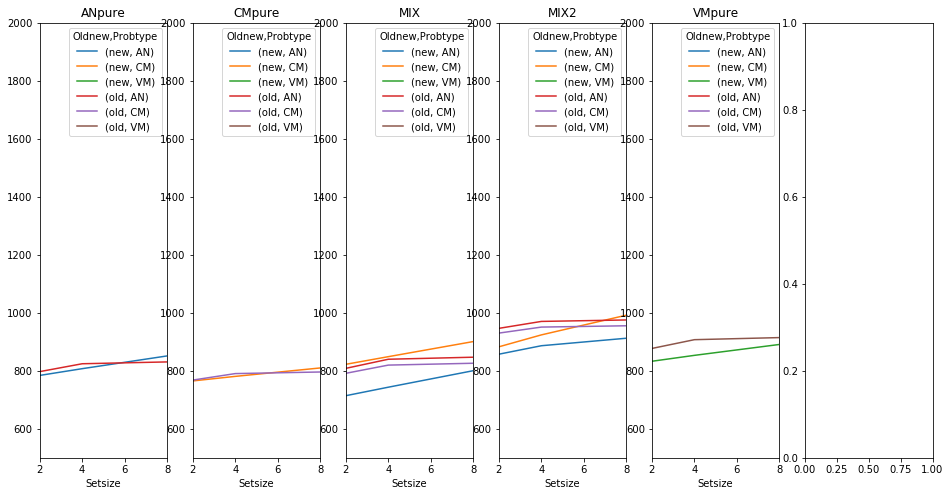

<Figure size 432x288 with 0 Axes>

In [30]:
[alpha["all"],beta["all"],s["all"],
    c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
    Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
    Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
    F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
    F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    [1.6205861261288248,  0.2,  0.01,  0.9899960020229178,  0.989997305885351, 
 0.9899845239478274,  0.989999546863487,  0.5356641737231739,  3.336283974964121, 
  -2.931487213477803,  3.155812289719721,  -2.7416418123801662,  3.7427211982968127, 
   -2.7643469613193927,  3.2637502649661827,  -3.437998558909658,  5.792511838173301, 
     -2.205339362112452,  267.71893048345225,  127.8899916115878,  77.4304109668687,  
   0.40622491800888794,  0.4162249180088885,  0.17587240322874048,  0.12183809720918663,  
   0.44179695884733705,  0.11183809720918376,  0.3876738898702132,  0.1155454160837328,  
   0.00012445471474345629,  0.3776738898702135,  0.39767388987021357,  0.1450626700175009,  
   0.00010238745679177577,  0.38527854855677035]  

df_crt_pred = finalRW(df_crt,"crt")
df_err_pred = finalRW(df_err,"err")

all_plot(df_crt_pred,"Pred_cRT",(500,2000))
# all_plot(df_crt_pred,"RT",(5,2000))
# all_plot(df_err_pred,"Pred_error",(0,0.3))
# all_plot(df_err,"Error",(0,0.3))

## True all_plot

In [43]:
def all_plot(df_all,plotwhaty,ylim):
    df_all_err = df_all.copy()
    df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
    df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
    df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1])

#     df_all_aggnew.index.name = 'Setsize'
    df_all_aggnew.reset_index(inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    plt.figure()
#     plt.title(plotwhaty)
    for iname in names:
        
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1
    
    plt.show()
    plt.close()   

## read fitsel from csv

In [274]:
fitsel

,alpha,beta,s,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool
0,0.3670763538168613,0.6901624496395286,0.030511443208974746,0.7141440449608176,4.567050226255028,-5.27254062231426,458.81972955449453,503.8383323847754,21.591164515491762,0.25626743273973024,0.2027300573118364,0.19273005737289975,0.17300670320601097
1,0.16865733078282616,2.153480448883181,0.053888485888634916,0.2659479954962367,5.311566553759647,-8.0,694.1731724497188,683.4212451569069,5.0,0.022397885355684977,0.1408385429485826,0.13083854294787226,2.0039075395397897e-14
2,0.44109179601195814,0.8697464865792425,0.028106781472422463,0.5978809971361752,3.9395626284414167,-4.433187020563635,450.9497402738318,506.67618787463596,30.184797386652477,0.17304998442372446,0.1648605670105302,0.1548605670105302,0.08753033597554759
3,0.38461512123995034,0.7379948816129482,0.02887510888904657,0.6793763591243129,4.197148281741437,-4.921275565776636,454.02758473818204,482.28530333218794,25.445199857323708,0.2331477085052058,0.16383758427408834,0.15383758427408833,0.16226896868757185
4,0.38916102280633363,0.6955426229400538,0.031210663063885744,0.8087922522707978,5.0319930423561114,-5.7742421355836395,464.3296063547273,499.7757500096961,17.70782132731559,0.33101075198960617,0.22378928716047236,0.21378928716047568,0.248315623815895
5,0.37199950953863775,0.706688962895521,0.029893522231870383,0.6864945667976983,4.379299673040658,-5.068055645346809,455.82007786991477,500.0419239949218,23.57151810323133,0.23555415140117106,0.18932410444667655,0.1793241044466765,0.15440751987989645
6,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0


In [400]:
# fitsel = pd.read_csv("11_25_02_36_single_test.csv").iloc[:,1:]

# fitsel = pd.read_csv("11_25_06_33_single_test.csv").iloc[:,1:]

fitsel = pd.read_csv("11_25_13_09_single_test_MIX2(big_change_wssd).csv").iloc[:,1:]
# [alpha["all"], beta["all"], s["all"],
#  c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
#  F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
#  F["MIX_AN_oldiold_oldinew"]]=\
# fitsel.iloc[1,:].astype(float).to_list()
# fitsel

## real try **

** 0 0    1.886721
0    0.000000
Name: wssd, dtype: float64 **


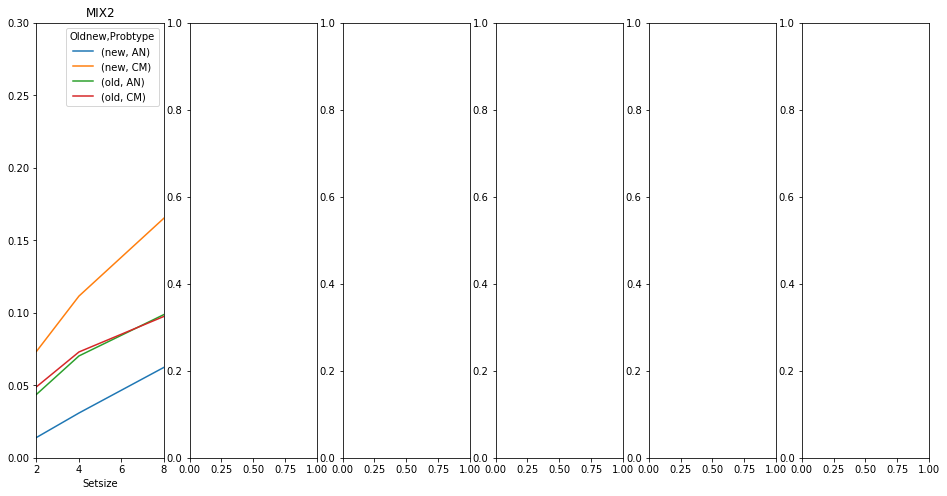

<Figure size 432x288 with 0 Axes>

** 1 2.5918689721246615 **


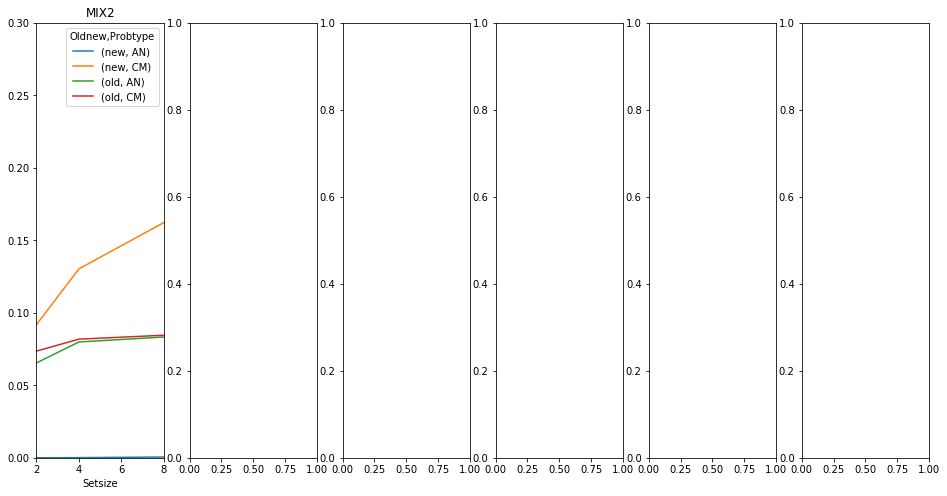

<Figure size 432x288 with 0 Axes>

** 2 13.044245588823024 **


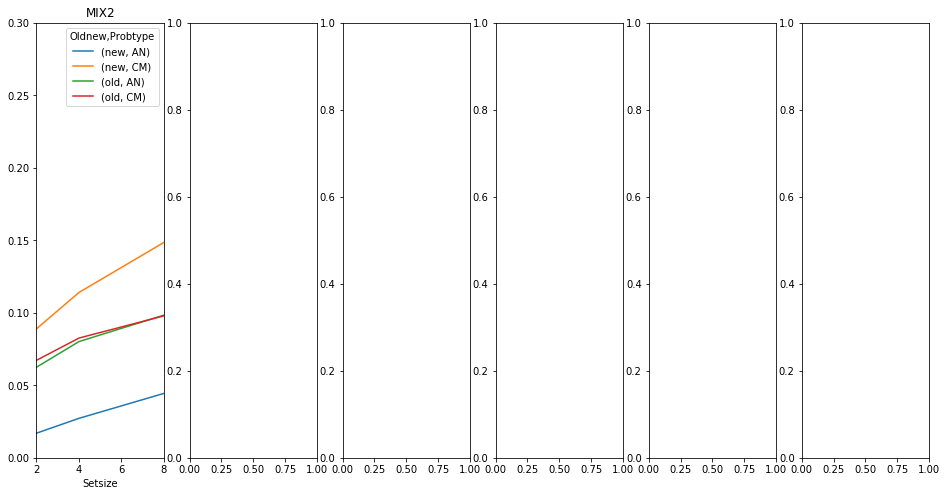

<Figure size 432x288 with 0 Axes>

** 3 0.2625520108885547 **


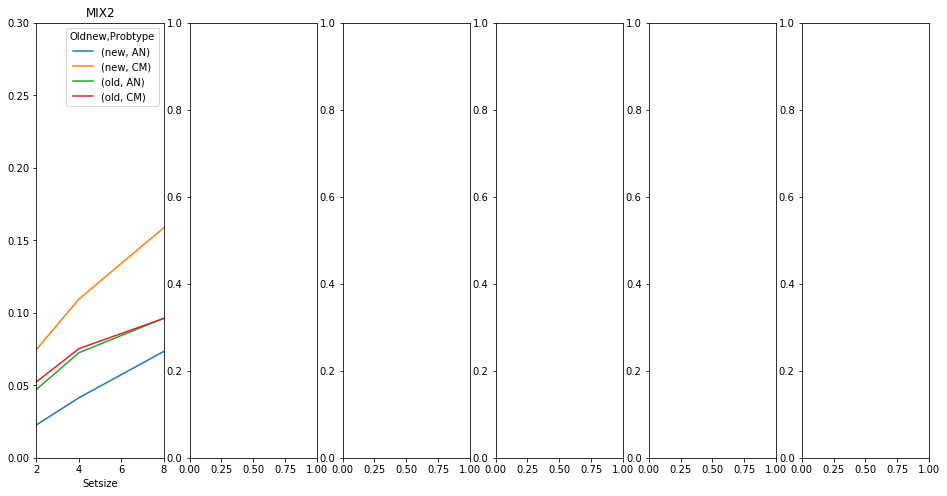

<Figure size 432x288 with 0 Axes>

** 4 12.226542856040208 **


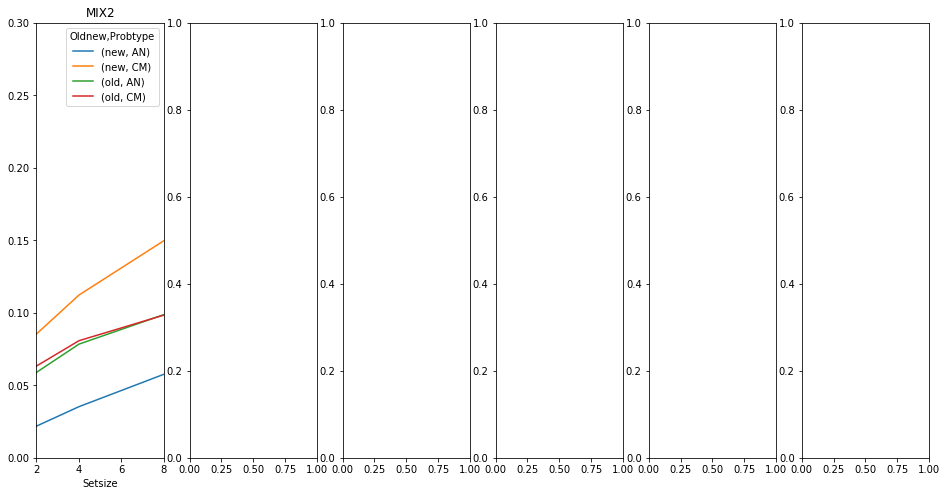

<Figure size 432x288 with 0 Axes>

true


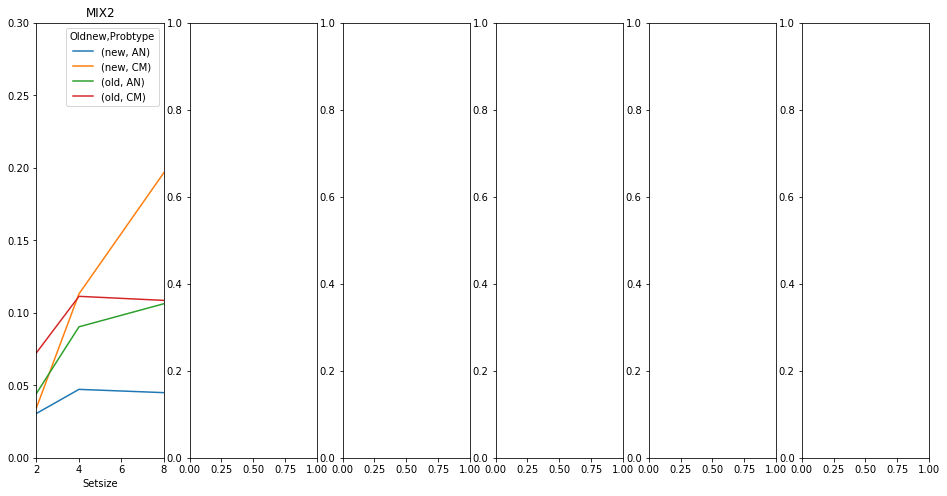

<Figure size 432x288 with 0 Axes>

In [44]:
search_MIX1=0
search_MIX2=1
for i in range(fitsel.shape[0]-1):
    

    [alpha["all"], beta["all"], s["ss2"],s["ss4"],s["ss8"],
     c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
     F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
     F["MIX2_AN_oldiold_oldinew"]]=\
    fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

    df_crt_sub=df_crt.copy()
    df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
    df_err_sub=df_err.copy()
    df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

    df_crt_pred = finalRW(df_crt_sub,"crt")
    df_err_pred = finalRW(df_err_sub,"err")
        

    print("**",i,fitsel["wssd"][i],"**")
    
    all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print("true")
        all_plot(df_err[df_err["FileCondi"]=="MIX2"],"Error",(0,0.3))

** 0 0    1.886721
0    0.000000
Name: wssd, dtype: float64 **


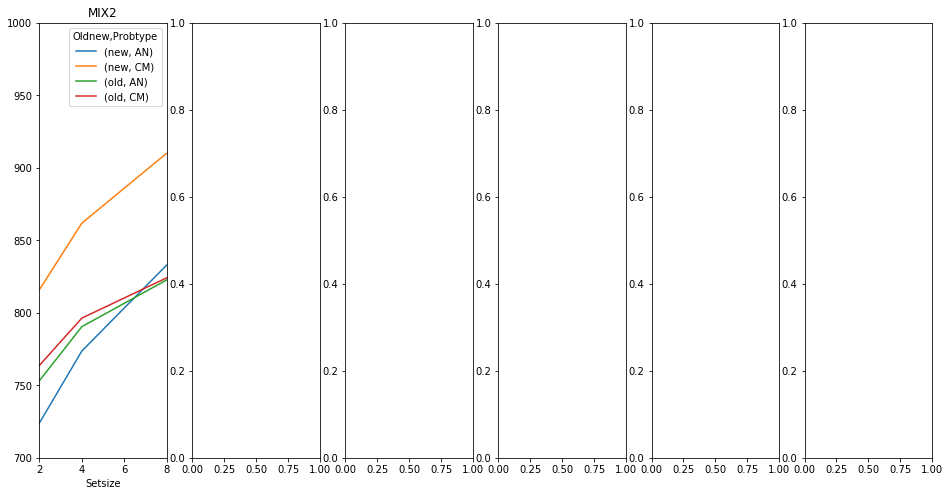

<Figure size 432x288 with 0 Axes>

** 1 2.5918689721246615 **


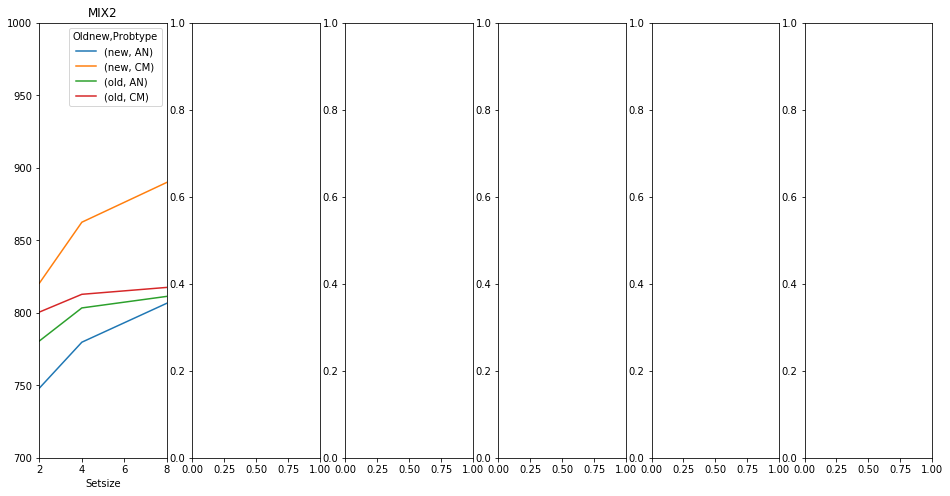

<Figure size 432x288 with 0 Axes>

** 2 13.044245588823024 **


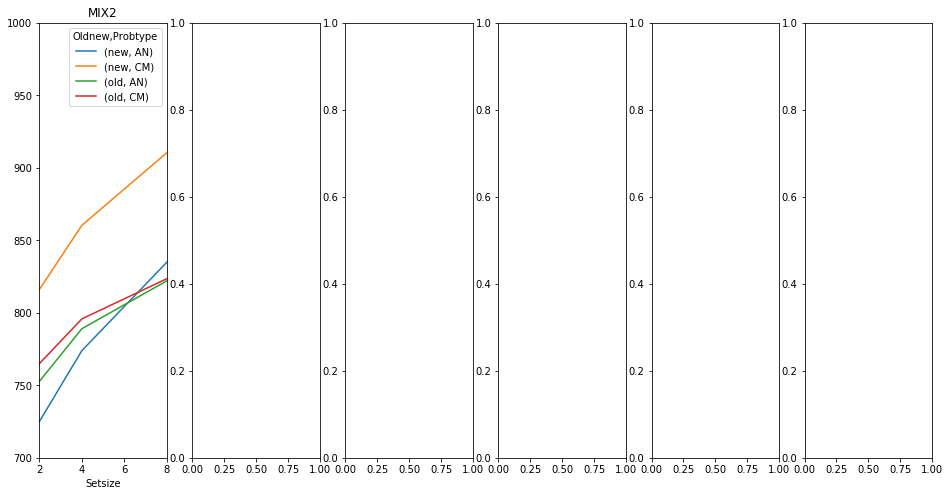

<Figure size 432x288 with 0 Axes>

** 3 0.2625520108885547 **


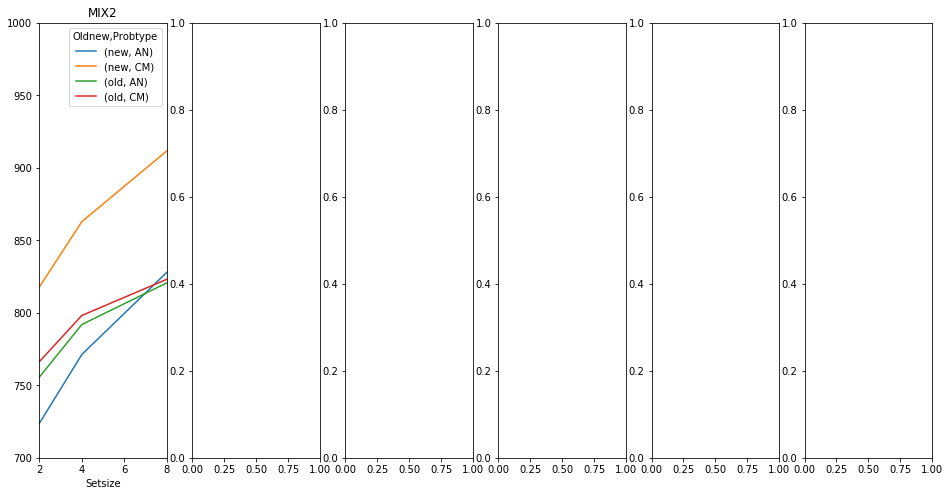

<Figure size 432x288 with 0 Axes>

** 4 12.226542856040208 **


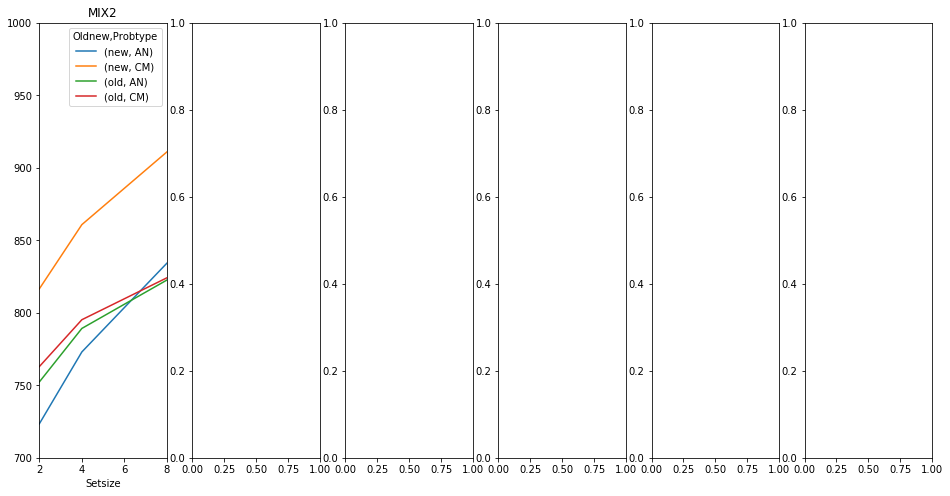

<Figure size 432x288 with 0 Axes>

true


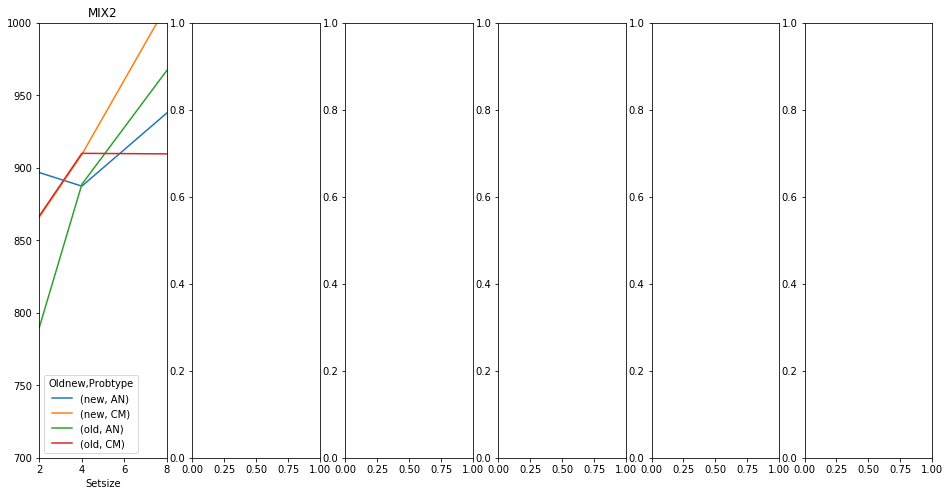

<Figure size 432x288 with 0 Axes>

In [45]:
for i in range(fitsel.shape[0]-1):


    [alpha["all"], beta["all"], s["ss2"],s["ss4"],s["ss8"],
     c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
     F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
     F["MIX2_AN_oldiold_oldinew"]]=\
    fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

    df_crt_sub=df_crt.copy()
    df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
    df_err_sub=df_err.copy()
    df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

    df_crt_pred = finalRW(df_crt_sub,"crt")
    df_err_pred = finalRW(df_err_sub,"err")
        
    print("**",i,fitsel["wssd"][i],"**")
    all_plot(df_crt_pred,"Pred_cRT",(700,1000))
#     all_plot(df_crt_pred,"RT",(5,2000))
#     all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print("true")
        all_plot(df_crt[df_crt["FileCondi"]=="MIX2"],"RT",(700,1000))

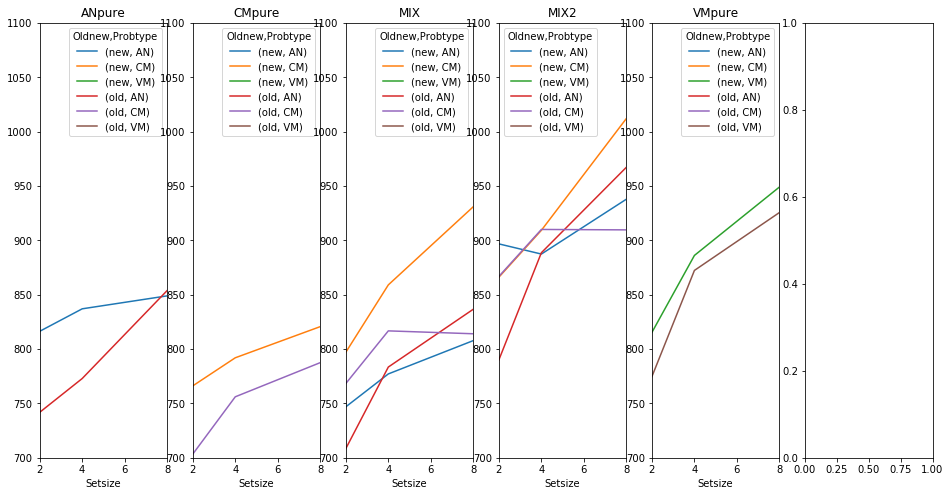

<Figure size 432x288 with 0 Axes>

In [50]:
all_plot(df_crt_pred,"Pred_cRT",(700,1100))
all_plot(df_crt_pred,"RT",(700,1100))

In [224]:
source("functions_fromr.r")

In [361]:
%get df_crt_pred --from Python3
%get df_err_pred --from Python3
%get df0 --from Python3

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


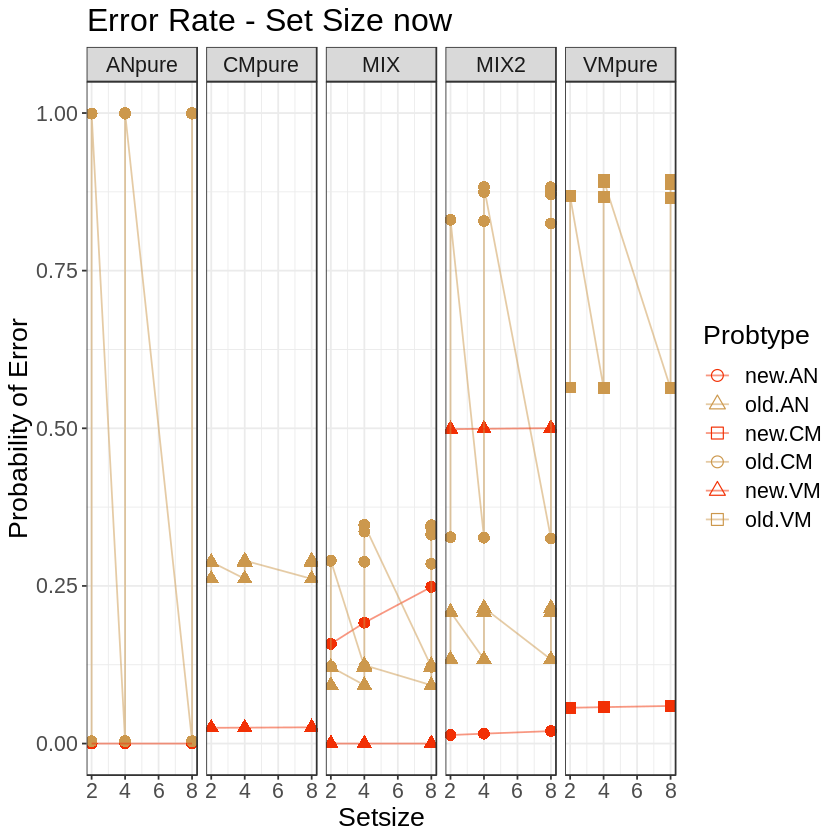

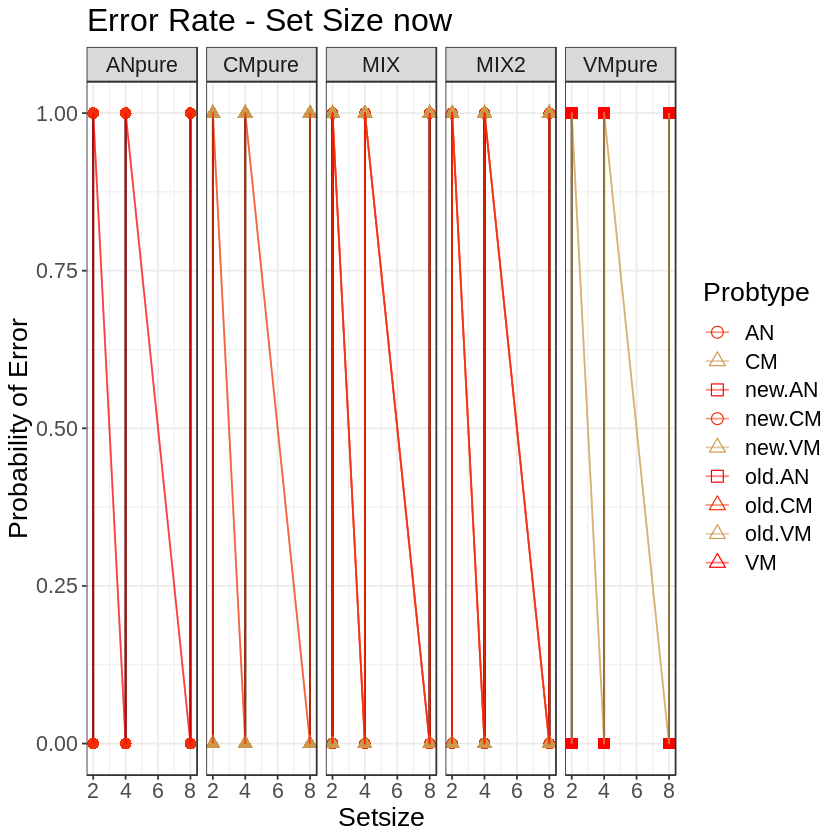

In [382]:
p.ER.pred=function(d,tit){
    override.shape = c(1,2,0,1,2,0)
  p=ggplot(data=d,aes(Setsize,Pred_error))+
    geom_point(aes(color=interaction(Oldnew,Probtype),shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p.ER.org=function(d,tit){
    override.shape = c(1,2,0,1,2,0,2,2,2)
  d0= d 
  dase= d %>% group_by(FileCondi,Oldnew,Setsize,Probtype,Correctness) %>%
    dplyr::summarize(Error=mean(Correctness),se=sd(Correctness)/sqrt(n()))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,Error))+
    geom_errorbar(aes(ymin=(Error-se), ymax=(1-Correctness)+se), width=.2,
                  position=position_dodge(.9),alpha=0.5) +
    geom_point(aes(color=Probtype,shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D","red"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")#+
#     coord_fixed(ratio=0.08)
  return(p)
}
p.ER.pred(df_err_pred,"now")
p.ER.org(df0,"now")